In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np
import utils

In [2]:
i_max = 100

device = '/cpu:0'
show = True

In [3]:
def create_noise_image(width, height):
    image = np.random.uniform(-32,32, (height, width, 3)).astype('float32')
    
    if(show == True):
        plt.imshow(image.reshape(height,width,3))
        plt.show()
    return image

In [4]:
def get_image(path):
    #load image
    img_input = utils.load_image(path)
    img = img_input.reshape((224, 224, 3))
    
    #show image
    if(show == True):
        plt.imshow(img)
        plt.show()
        
    return img

In [5]:
def get_loss(t, i):
    #get error
    diff = 2 * tf.nn.l2_loss(t - i)
    return diff

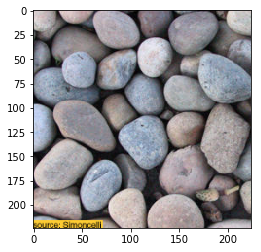

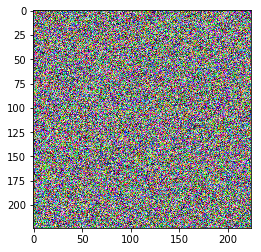

In [6]:
with tf.device(device):
    sess = tf.Session()
    
    #placeholders
    input_image = tf.placeholder(tf.float32, [224, 224, 3])
    #target_image = tf.placeholder(tf.float32, [1, 224, 224, 3])
    
    #load style image
    input_img = get_image("./test_data/pebbles.jpg")
    #create target image
    target_img = (create_noise_image(224, 224))
                 
    #create variables                 
    target = tf.Variable(target_img, tf.float32)
    
    loss = get_loss(input_image, target)
    
    
    #handlers
    #optimizer = tf.train.AdamOptimizer(0.5)
    optimizer = tf.train.GradientDescentOptimizer(0.5)
    minimize = optimizer.minimize(loss)
    
    #init
    sess.run(tf.global_variables_initializer())
    
    #init adam
    #sess.run(tf.initialize_all_variables())

2.73877e-08


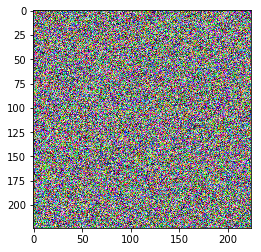

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


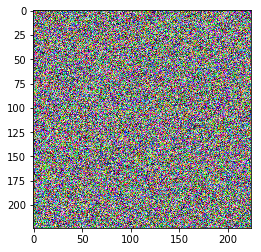

In [7]:
    #fill feed dictionary
    feed = {input_image: input_img}
    
    for i in range(i_max):
        
        #optimize step
        sess.run(minimize, feed_dict = feed)
        
        #print loss
        print(sess.run(loss, feed_dict = feed))
        
        
        #show image
        if(show == True):
            if(i == 0):
                plt.imshow(target_img.reshape((224,224,3)))
                plt.show()
            if(i == 99):
                plt.imshow(target_img.reshape((224,224,3)))
                plt.show()